In [3]:
from src.debate_manager import DebateManager
import logging
import os
from openai import OpenAI
from src.prompts import create_one_example

In [5]:
api_key = os.environ["OPENAI_API_KEY"]
client = OpenAI(api_key=api_key)

In [6]:
manager = DebateManager("config/data_config.yaml", debate_format="debateart")
debate = manager.load_debate('0017')

Loaded Config: {'datasets': {'bp_competition': {'data_dir': 'data/panel_bench/BP-Competition', 'formats': {'motion': 'motion/bp_{id}.yml', 'speech': 'speech/bp_{id}.yml'}}, 'debateart': {'data_dir': 'data/panel_bench/DebateArt', 'formats': {'motion': 'motion/debateart_{id}.yml', 'speech': 'speech/debateart_{id}.yml'}}}}


In [7]:
print(debate)

{'id': '0017', 'format': 'debateart', 'motion': {'motion': 'Faith and belief are useless in the pursuit of truth', 'pro_side': [{'name': 'Type1'}], 'con_side': [{'name': 'drafterman'}], 'info_slide': 'No information', 'speech_order': ['Type1', 'drafterman', 'Type1', 'drafterman', 'Type1', 'drafterman']}, 'speech': [{'debater_name': 'Type1', 'content': 'There is an objective truth, and it does not care about anyone\'s opinions or feelings.\\\nHumans are highly superstitious animals, and it is actually the norm to be delusional in human societies. There very fabric of the average human mind consists of social constructs, subjective perceptions, and superstitions that we call beliefs and opinions. The scientific method was designed to ascertain object truths about the physical mechanics of reality (although it cannot ascertain the essence of reality, what something "is". Only it\'s properties and behaviour). Even most scientists however do not think scientifically, a scientist is someone 

In [17]:
from pydantic import BaseModel, Field
from typing import List, Optional, Dict
from datetime import datetime
from uuid import UUID, uuid4

class ArgumentEntity(BaseModel):
    id: int
    type: str = "argument"
    content: str

class Relationship(BaseModel):
    source_id: int
    target_id: int
    relationship_type: str = Field(..., description="Relationship types: [claim, premise, conclusion, first principle, rebuttal]")

class DebateGraph(BaseModel):
    entities: List[ArgumentEntity]
    relationships: List[Relationship]

In [18]:
# Create a debate graph about climate change
main_claim = ArgumentEntity(
    id=1,
    content="Climate change poses a serious threat to global ecosystems and human society"
)

supporting_premise1 = ArgumentEntity(
    id=2,
    content="Global temperatures have risen by approximately 1°C since pre-industrial times"
)

supporting_premise2 = ArgumentEntity(
    id=3,
    content="Rising temperatures are primarily caused by human greenhouse gas emissions"
)

conclusion = ArgumentEntity(
    id=4,
    content="Immediate action is required to reduce greenhouse gas emissions"
)

rebuttal = ArgumentEntity(
    id=5,
    content="Natural climate cycles have caused temperature variations throughout Earth's history"
)

first_principle = ArgumentEntity(
    id=6,
    content="Scientific measurements and data provide reliable evidence for understanding climate patterns"
)

# Create relationships between arguments
relationships = [
    Relationship(
        source_id=supporting_premise1.id,
        target_id=main_claim.id,
        relationship_type="premise"
    ),
    Relationship(
        source_id=supporting_premise2.id,
        target_id=main_claim.id,
        relationship_type="premise"
    ),
    Relationship(
        source_id=main_claim.id,
        target_id=conclusion.id,
        relationship_type="claim"
    ),
    Relationship(
        source_id=rebuttal.id,
        target_id=supporting_premise2.id,
        relationship_type="rebuttal"
    ),
    Relationship(
        source_id=first_principle.id,
        target_id=supporting_premise1.id,
        relationship_type="first principle"
    )
]

# Create the debate graph
debate_graph = DebateGraph(
    entities=[main_claim, supporting_premise1, supporting_premise2, conclusion, rebuttal, first_principle],
    relationships=relationships
)

# Print the JSON representation
example_graph = debate_graph.model_dump_json(indent=2)

In [20]:
print(example_graph) #example_graph

{
  "entities": [
    {
      "id": 1,
      "type": "argument",
      "content": "Climate change poses a serious threat to global ecosystems and human society"
    },
    {
      "id": 2,
      "type": "argument",
      "content": "Global temperatures have risen by approximately 1°C since pre-industrial times"
    },
    {
      "id": 3,
      "type": "argument",
      "content": "Rising temperatures are primarily caused by human greenhouse gas emissions"
    },
    {
      "id": 4,
      "type": "argument",
      "content": "Immediate action is required to reduce greenhouse gas emissions"
    },
    {
      "id": 5,
      "type": "argument",
      "content": "Natural climate cycles have caused temperature variations throughout Earth's history"
    },
    {
      "id": 6,
      "type": "argument",
      "content": "Scientific measurements and data provide reliable evidence for understanding climate patterns"
    }
  ],
  "relationships": [
    {
      "source_id": 2,
      "target_id"

In [21]:
def create_scene_graph_prompt(topic, side, speech):
    base_prompt = f"""
    You are an AI agent tasked with analyzing a debate. The topic of the debate is: "{topic}". 
    You are representing the {side} side. Below is a speech from your side:

    "{speech}"

    Based on this speech without making up new arguments, generate a scene graph in JSON format that includes the following:
    1. Arguments, and relationships that are most relevant to understanding your side's speech and point of view.
    2. Ensure the relations used are one of the following: ["claim", "premise", "conclusion", "first principle", "rebuttal"]
    3. The scene graph should be structured to clearly represent the key points and relationships in the argument.
    4. All ids should be unique

    Here is an example scene graph for climate change, you should follow this format in your generated scene graph:

    "{example_graph}"

    Please provide the scene graph between the markers <SCENE_GRAPH> and </SCENE_GRAPH>
    """

    return base_prompt

In [64]:
import json

def extract_scene_graph(response):
    start_marker = "<SCENE_GRAPH>"
    end_marker = "</SCENE_GRAPH>"
    
    start_index = response.find(start_marker) + len(start_marker)
    end_index = response.find(end_marker)
    
    scene_graph_json = response[start_index:end_index].strip()
    return DebateGraph.model_validate_json(scene_graph_json)

def display_scene_graph(scene_graph):
    print(json.dumps(scene_graph, indent=4))

In [24]:
debate['motion']['motion']

'Faith and belief are useless in the pursuit of truth'

In [25]:
prompt = create_scene_graph_prompt(debate['motion']['motion'], 'pro', debate['speech'][0]['content'])
print(prompt)


    You are an AI agent tasked with analyzing a debate. The topic of the debate is: "Faith and belief are useless in the pursuit of truth". 
    You are representing the pro side. Below is a speech from your side:

    "There is an objective truth, and it does not care about anyone's opinions or feelings.\
Humans are highly superstitious animals, and it is actually the norm to be delusional in human societies. There very fabric of the average human mind consists of social constructs, subjective perceptions, and superstitions that we call beliefs and opinions. The scientific method was designed to ascertain object truths about the physical mechanics of reality (although it cannot ascertain the essence of reality, what something "is". Only it's properties and behaviour). Even most scientists however do not think scientifically, a scientist is someone who uses science to achieve certain goals, but the majority of them still think like normal people in everyday life. A scientific thinker 

In [26]:
def generate(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

In [27]:
response = generate(prompt)

In [29]:
print(response)

<SCENE_GRAPH>
{
  "entities": [
    {
      "id": 1,
      "type": "argument",
      "content": "There is an objective truth that is independent of opinions or feelings"
    },
    {
      "id": 2,
      "type": "argument",
      "content": "Humans are inherently superstitious and tend to hold delusional beliefs"
    },
    {
      "id": 3,
      "type": "argument",
      "content": "The scientific method is designed to ascertain objective truths about reality"
    },
    {
      "id": 4,
      "type": "argument",
      "content": "Most people, including scientists, do not think scientifically in everyday life"
    },
    {
      "id": 5,
      "type": "argument",
      "content": "A scientific thinker holds to speculation, inquiry, theory, and proven facts"
    },
    {
      "id": 6,
      "type": "argument",
      "content": "Faith and belief lead to subjective perceptions and social constructs"
    },
    {
      "id": 7,
      "type": "argument",
      "content": "The average huma

In [32]:
sg = extract_scene_graph(response)

In [33]:
sg

{'entities': [{'id': 1,
   'type': 'argument',
   'content': 'There is an objective truth that is independent of opinions or feelings'},
  {'id': 2,
   'type': 'argument',
   'content': 'Humans are inherently superstitious and tend to hold delusional beliefs'},
  {'id': 3,
   'type': 'argument',
   'content': 'The scientific method is designed to ascertain objective truths about reality'},
  {'id': 4,
   'type': 'argument',
   'content': 'Most people, including scientists, do not think scientifically in everyday life'},
  {'id': 5,
   'type': 'argument',
   'content': 'A scientific thinker holds to speculation, inquiry, theory, and proven facts'},
  {'id': 6,
   'type': 'argument',
   'content': 'Faith and belief lead to subjective perceptions and social constructs'},
  {'id': 7,
   'type': 'argument',
   'content': 'The average human is a vessel for environmental and conditioned values, ideas, and opinions'}],
 'relationships': [{'source_id': 1,
   'target_id': 3,
   'relationship_typ

In [36]:
pydantic_scene_graph = DebateGraph.model_validate(sg)
pydantic_scene_graph

DebateGraph(entities=[ArgumentEntity(id=1, type='argument', content='There is an objective truth that is independent of opinions or feelings'), ArgumentEntity(id=2, type='argument', content='Humans are inherently superstitious and tend to hold delusional beliefs'), ArgumentEntity(id=3, type='argument', content='The scientific method is designed to ascertain objective truths about reality'), ArgumentEntity(id=4, type='argument', content='Most people, including scientists, do not think scientifically in everyday life'), ArgumentEntity(id=5, type='argument', content='A scientific thinker holds to speculation, inquiry, theory, and proven facts'), ArgumentEntity(id=6, type='argument', content='Faith and belief lead to subjective perceptions and social constructs'), ArgumentEntity(id=7, type='argument', content='The average human is a vessel for environmental and conditioned values, ideas, and opinions')], relationships=[Relationship(source_id=1, target_id=3, relationship_type='premise'), Re

In [61]:
def combine_debate_graphs(graph1: DebateGraph, graph2: DebateGraph) -> DebateGraph:
    """
    Combines two DebateGraph objects into a single DebateGraph.
    
    Args:
        graph1 (DebateGraph): First debate graph
        graph2 (DebateGraph): Second debate graph
        
    Returns:
        DebateGraph: A new debate graph containing all entities and relationships from both graphs
    """
    # Create sets of entity IDs to check for duplicates
    existing_entity_ids = {entity.id for entity in graph1.entities}
    
    # Combine entities, avoiding duplicates based on ID
    combined_entities = list(graph1.entities)
    for entity in graph2.entities:
        if entity.id not in existing_entity_ids:
            combined_entities.append(entity)
            existing_entity_ids.add(entity.id)
    
    # Combine relationships
    combined_relationships = list(graph1.relationships)
    for rel in graph2.relationships:
        # Only add relationship if both source and target entities exist in combined entities
        if any(e.id == rel.source_id for e in combined_entities) and \
            any(e.id == rel.target_id for e in combined_entities):
            combined_relationships.append(rel)
    
    # Create new DebateGraph with combined entities and relationships
    return DebateGraph(
        entities=combined_entities,
        relationships=combined_relationships
    )

In [51]:
def create_counterfactual_scene_graph_prompt(topic, con_speech, pro_scene_graph):
    base_prompt = f"""
    You are an AI agent representing the con side in a debate. The topic of the debate is: "{topic}". 
    Below is a speech from your side:

    "{con_speech}"

    Additionally, here is the current scene graph representing the debate which has just been modified by the pro side:

    {json.dumps(pro_scene_graph, indent=2)}

    Your task is to generate counterfactual argument entities and relationships in the same JSON format that refutes the pro side's arguments and introduces new arguments for the con side. All of your arguments should be based on the given con side speech, do not make up new arguments that are not mentioned in the con side speech. The counterfactual scene graph should include the following:
    1. Arguments, and relationships that directly counter the pro side's scene graph.
    2. Arguments, and relationships that support the con side's arguments.
    3. The scene graph should be structured to clearly represent the key points and relationships in the argument.
    4. Make reference to the pro side's arguments by referencing their ids in the your proposed relations.
    5. Do not include duplicates of the pro side's arguments in your graph when you could instead reference their ids in your relations.
    6. Do not add any new fields to the json which are not in the provided examples.
    7. Source and Target Id should always refer to an integer of an existing argument.
    8. All generated argument ids should be unique from any other id in the current scene graph.

    Your proposed arguments and relationships will be added to the scene graph to form an update debate graph from which a judge can determine the winner.

    Here is an example another example scene graph for climate change which you can use as reference for the format of your json output:

    "{example_graph}"

    Please provide the counterfactual scene graph between the markers <SCENE_GRAPH> and </SCENE_GRAPH>.

    You should additionally provide a brief explanation of the counterfactual scene graph between the markers <EXPLANATION> and </EXPLANATION>.
    """

    return base_prompt

In [52]:
def create_pro_counterfactual_scene_graph_prompt(topic, pro_speech, con_scene_graph):
    base_prompt = f"""
    You are an AI agent representing the pro side in a debate. The topic of the debate is: "{topic}". 
    Below is a speech from your side:

    "{pro_speech}"

    Additionally, here is the current scene graph representing the debate which has just been modified by the con side:

    {json.dumps(con_scene_graph, indent=2)}

    Your task is to generate counterfactual argument entities and relationships in the same JSON format that refutes the con side's arguments and introduces new arguments for the pro side. All of your arguments should be based on the given pro side speech, do not make up new arguments that are not mentioned in the pro side speech. The counterfactual scene graph should include the following:
    1. Arguments, and relationships that directly counter the con side's scene graph.
    2. Arguments, and relationships that support the pro side's arguments.
    3. The scene graph should be structured to clearly represent the key points and relationships in the argument.
    4. Make reference to the con side's arguments by referencing their ids in the your proposed relations.
    5. Do not include duplicates of the con side's arguments in your graph when you could instead reference their ids in your relations.
    6. Do not add any new fields to the json which are not in the provided examples.
    7. Source and Target Id should always refer to an integer of an existing argument.
    8. All generated argument ids should be unique from any other id in the current scene graph.

    Your proposed arguments and relationships will be added to the scene graph to form an update debate graph from which a judge can determine the winner.

    Here is an example another example scene graph for climate change which you can use as reference for the format of your json output:

    "{example_graph}"

    Please provide the counterfactual scene graph between the markers <SCENE_GRAPH> and </SCENE_GRAPH>.

    You should additionally provide a brief explanation of the counterfactual scene graph between the markers <EXPLANATION> and </EXPLANATION>.
    """

    return base_prompt

In [55]:
debate

{'id': '0017',
 'format': 'debateart',
 'motion': {'motion': 'Faith and belief are useless in the pursuit of truth',
  'pro_side': [{'name': 'Type1'}],
  'con_side': [{'name': 'drafterman'}],
  'info_slide': 'No information',
  'speech_order': ['Type1',
   'drafterman',
   'Type1',
   'drafterman',
   'Type1',
   'drafterman']},
 'speech': [{'debater_name': 'Type1',
   'content': 'There is an objective truth, and it does not care about anyone\'s opinions or feelings.\\\nHumans are highly superstitious animals, and it is actually the norm to be delusional in human societies. There very fabric of the average human mind consists of social constructs, subjective perceptions, and superstitions that we call beliefs and opinions. The scientific method was designed to ascertain object truths about the physical mechanics of reality (although it cannot ascertain the essence of reality, what something "is". Only it\'s properties and behaviour). Even most scientists however do not think scientific

In [40]:
# Assuming DebateManager is already imported and configured
manager = DebateManager("config/data_config.yaml", debate_format="debateart")
debate = manager.load_debate('0017')

topic = debate['motion']['motion']
pro_speeches = [speech['content'] for speech in debate['speech'] if speech['debater_name'] == debate['motion']['pro_side'][0]['name']]
con_speeches = [speech['content'] for speech in debate['speech'] if speech['debater_name'] == debate['motion']['con_side'][0]['name']]

Loaded Config: {'datasets': {'bp_competition': {'data_dir': 'data/panel_bench/BP-Competition', 'formats': {'motion': 'motion/bp_{id}.yml', 'speech': 'speech/bp_{id}.yml'}}, 'debateart': {'data_dir': 'data/panel_bench/DebateArt', 'formats': {'motion': 'motion/debateart_{id}.yml', 'speech': 'speech/debateart_{id}.yml'}}}}


In [63]:
# Initialize empty scene graphs and history lists
pro_scene_graph = {}
con_scene_graph = {}
graph_history = []

# Iterate over speeches
for i, (pro_speech, con_speech) in enumerate(zip(pro_speeches, con_speeches)):
    # Generate pro side counterfactual prompt
    if i == 0:
        pro_prompt = create_scene_graph_prompt(topic, 'pro', pro_speech)
        pro_response = generate(pro_prompt)
        scene_graph = extract_scene_graph(pro_response)
    else:
        pro_prompt = create_pro_counterfactual_scene_graph_prompt(topic, pro_speech, scene_graph.model_dump())
        result = None
        while result is None:
            try:
                pro_response = generate(pro_prompt)
                pro_scene_graph = extract_scene_graph(pro_response)
                result = combine_debate_graphs(pro_scene_graph,scene_graph)
            except Exception as e:
                pass
        scene_graph = result

    graph_history.append(scene_graph.model_dump())

    print(f"Pro Scene Graph {i+1}:\n")
    display_scene_graph(scene_graph.model_dump())
    # Generate con side counterfactual prompt
    con_prompt = create_counterfactual_scene_graph_prompt(topic, con_speech, scene_graph.model_dump())
    result = None
    while result is None:
        try:
            con_response = generate(con_prompt)
            con_scene_graph = extract_scene_graph(con_response)
            result = combine_debate_graphs(con_scene_graph,scene_graph)
        except Exception as e:
            pass
    scene_graph = result

    # Save con scene graph to history
    graph_history.append(scene_graph.model_dump())

    # Display the scene graphs
    print(f"Con Scene Graph {i+1}:\n")
    display_scene_graph(scene_graph.model_dump())

{
  "entities": [
    {
      "id": 1,
      "type": "argument",
      "content": "There is an objective truth, and it does not care about anyone's opinions or feelings."
    },
    {
      "id": 2,
      "type": "argument",
      "content": "Humans are highly superstitious animals, and it is the norm to be delusional in human societies."
    },
    {
      "id": 3,
      "type": "argument",
      "content": "The scientific method was designed to ascertain objective truths."
    },
    {
      "id": 4,
      "type": "argument",
      "content": "A scientific thinker is someone who has no beliefs or opinions about reality."
    },
    {
      "id": 5,
      "type": "argument",
      "content": "Average humans are vessels for values, ideas, and opinions they receive from their environment."
    }
  ],
  "relationships": [
    {
      "source_id": 2,
      "target_id": 1,
      "relationship_type": "premise"
    },
    {
      "source_id": 3,
      "target_id": 1,
      "relationship_type

In [59]:
js = """
{
  "entities": [
    {
      "id": 109,
      "type": "argument",
      "content": "Beliefs are necessary to establish foundational premises in any pursuit of knowledge, including science."
    },
    {
      "id": 110,
      "type": "argument",
      "content": "Assumptions and axioms are beliefs that underpin the scientific method and allow for exploration and discovery."
    },
    {
      "id": 111,
      "type": "argument",
      "content": "A belief or assumption is necessary to avoid an infinite regress in logical arguments."
    },
    {
      "id": 112,
      "type": "argument",
      "content": "Popper acknowledged that beliefs and conjectures are useful in science for formulating hypotheses to be tested through falsification."
    }
  ],
  "relationships": [
    {
      "source_id": 109,
      "target_id": 101,
      "relationship_type": "rebuttal"
    },
    {
      "source_id": 110,
      "target_id": 105,
      "relationship_type": "rebuttal"
    },
    {
      "source_id": 109,
      "target_id": 107,
      "relationship_type": "rebuttal"
    },
    {
      "source_id": 111,
      "target_id": 102,
      "relationship_type": "rebuttal"
    },
    {
      "source_id": 112,
      "target_id": 105,
      "relationship_type": "rebuttal"
    },
    {
      "source_id": 110,
      "target_id": 109,
      "relationship_type": "support"
    },
    {
      "source_id": 112,
      "target_id": 109,
      "relationship_type": "support"
    }
  ]
}
"""
DebateGraph.model_validate_json(js)

DebateGraph(entities=[ArgumentEntity(id=109, type='argument', content='Beliefs are necessary to establish foundational premises in any pursuit of knowledge, including science.'), ArgumentEntity(id=110, type='argument', content='Assumptions and axioms are beliefs that underpin the scientific method and allow for exploration and discovery.'), ArgumentEntity(id=111, type='argument', content='A belief or assumption is necessary to avoid an infinite regress in logical arguments.'), ArgumentEntity(id=112, type='argument', content='Popper acknowledged that beliefs and conjectures are useful in science for formulating hypotheses to be tested through falsification.')], relationships=[Relationship(source_id=109, target_id=101, relationship_type='rebuttal'), Relationship(source_id=110, target_id=105, relationship_type='rebuttal'), Relationship(source_id=109, target_id=107, relationship_type='rebuttal'), Relationship(source_id=111, target_id=102, relationship_type='rebuttal'), Relationship(source_

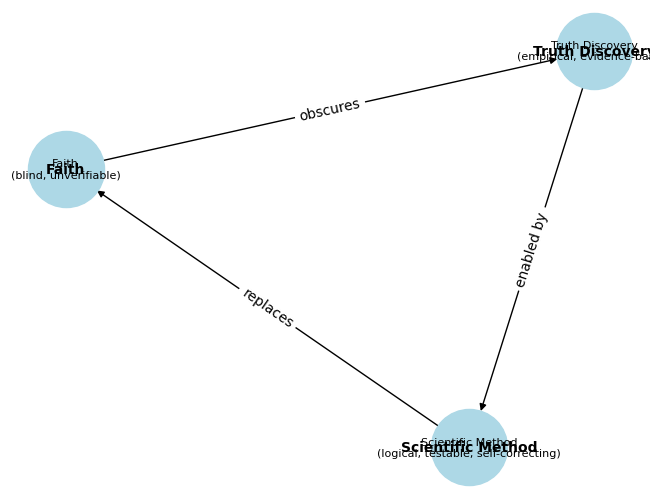

In [82]:
import networkx as nx
import matplotlib.pyplot as plt

def graph_scene_graph(scene_graph):
    G = nx.DiGraph()  # Use a directed graph to represent relationships

    # Add nodes with attributes
    for obj in scene_graph['objects']:
        # Convert list of attributes to a string for display
        attributes = ', '.join(obj['attributes'])
        G.add_node(obj['name'], attributes=attributes)

    # Add edges with relationship types
    for rel in scene_graph['relationships']:
        source_name = next(obj['name'] for obj in scene_graph['objects'] if obj['id'] == rel['source'])
        target_name = next(obj['name'] for obj in scene_graph['objects'] if obj['id'] == rel['target'])
        G.add_edge(source_name, target_name, relationship=rel['type'])

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Display node attributes
    node_labels = {node: f"{node}\n({data['attributes']})" for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    plt.show()

# Call the function to display the graph
graph_scene_graph(pro_scene_graph)

Pro Scene Graph 1:


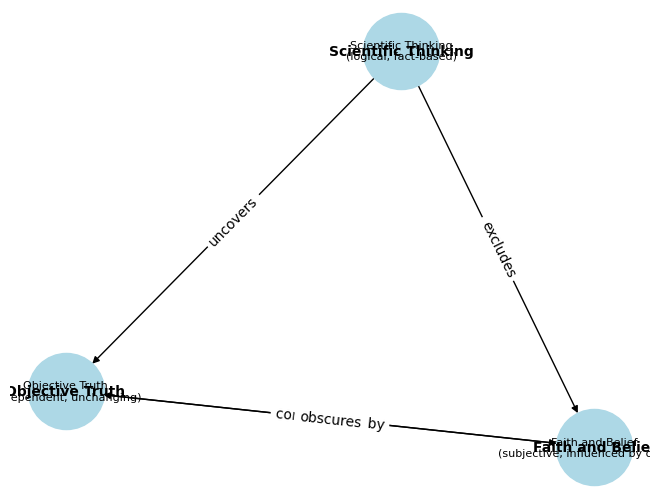

Con Scene Graph 1:


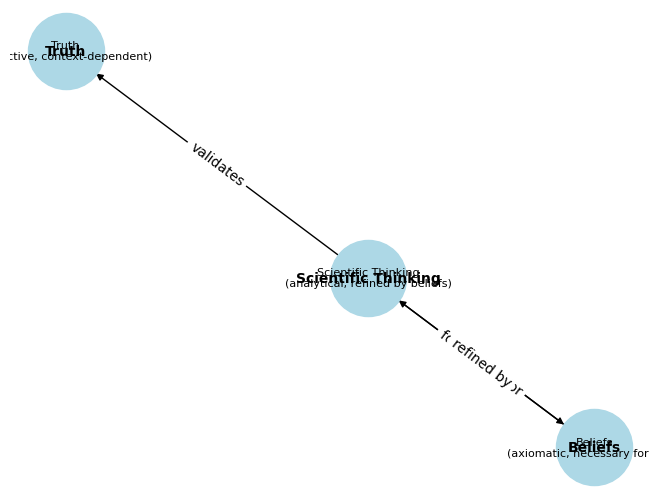

Pro Scene Graph 2:


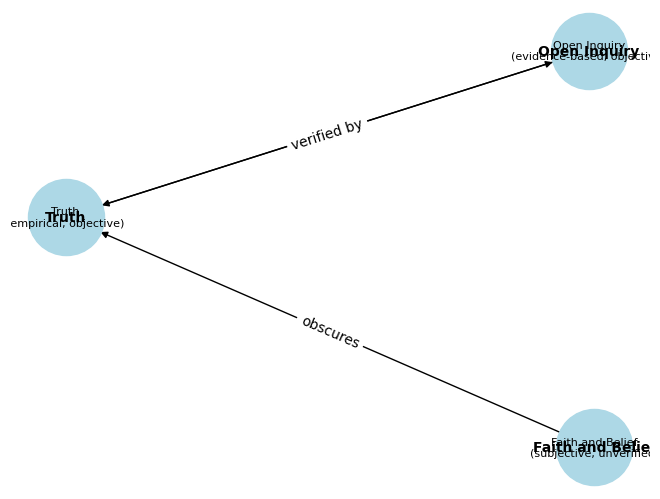

Con Scene Graph 2:


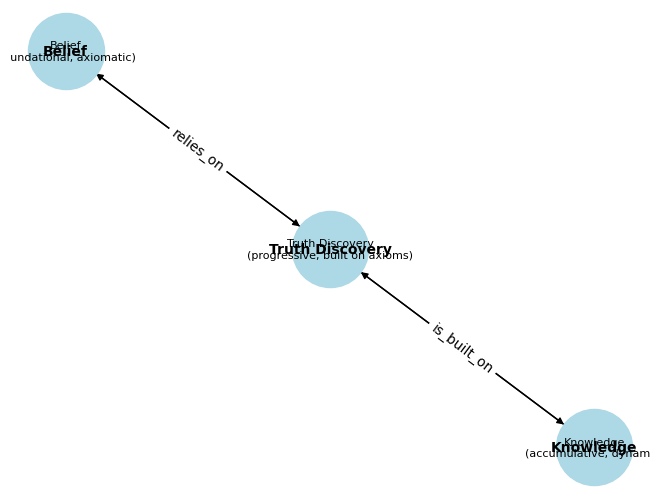

Pro Scene Graph 3:


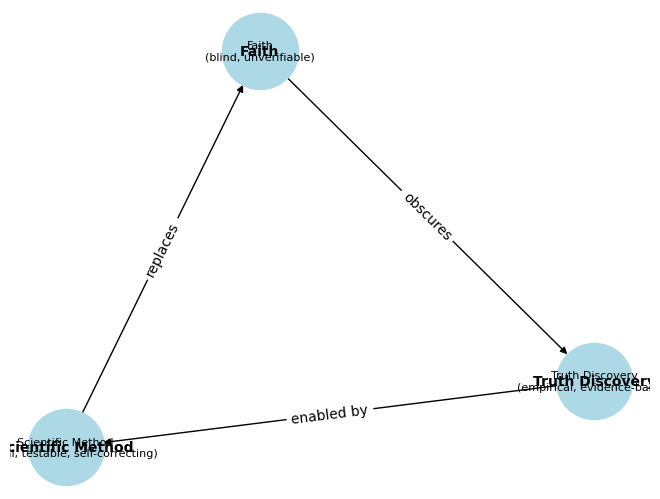

Con Scene Graph 3:


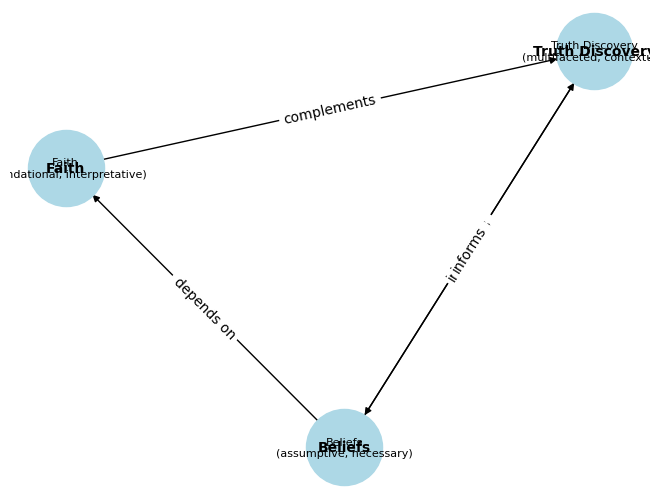

In [83]:
# Function to graph all scene graphs in the history list
def graph_all_scene_graphs(pro_scene_graph_history, con_scene_graph_history):
    for i, (pro_scene_graph, con_scene_graph) in enumerate(zip(pro_scene_graph_history, con_scene_graph_history)):
        print(f"Pro Scene Graph {i+1}:")
        graph_scene_graph(pro_scene_graph)
        print(f"Con Scene Graph {i+1}:")
        graph_scene_graph(con_scene_graph)

# Assuming pro_scene_graph_history and con_scene_graph_history are defined and populated
graph_all_scene_graphs(pro_scene_graph_history, con_scene_graph_history)


In [65]:
def create_judge_prompt(topic, scene_graph, thoughts_history):
    base_prompt = f"""
    You are an AI judge tasked with evaluating the logical validity of arguments in a debate. The topic of the debate is: "{topic}". 
    Below is the scene graph generated by the pro and con sides:

    Scene Graph:
    {json.dumps(scene_graph, indent=4)}

    Additionally, here is the history of your previous thoughts:
    {thoughts_history}

    Your task is to analyze the logical structure and validity of each side's arguments based on the scene graph. Consider the relationships and attributes in the graph to determine the strength and coherence of the arguments. Provide your reasoning and conclusion wrapped in <thoughts> tags. Based on this analysis and the history of your previous thoughts, decide which side has presented a stronger argument. If the pro side has a stronger argument, write <winner>pro</winner>. If the con side has a stronger argument, write <winner>con</winner>. If both sides are equally strong, write <winner>tie</winner>.

    Please provide your reasoning and conclusion between the markers <thoughts> and </thoughts>, and your decision between the markers <winner> and </winner>.
    """

    return base_prompt

In [66]:
def extract_thoughts_and_winner(judge_response):
    # Extract thoughts
    thoughts_start = judge_response.find("<thoughts>") + len("<thoughts>")
    thoughts_end = judge_response.find("</thoughts>")
    thoughts = judge_response[thoughts_start:thoughts_end].strip()

    # Extract winner
    winner_start = judge_response.find("<winner>") + len("<winner>")
    winner_end = judge_response.find("</winner>")
    winner = judge_response[winner_start:winner_end].strip()

    return thoughts, winner

In [108]:
def process_debate(debate):
    topic = debate['motion']['motion']
    pro_speeches = [speech['content'] for speech in debate['speech'] if speech['debater_name'] == debate['motion']['pro_side'][0]['name']]
    con_speeches = [speech['content'] for speech in debate['speech'] if speech['debater_name'] == debate['motion']['con_side'][0]['name']]

    pro_scene_graph = {}
    con_scene_graph = {}
    scene_graph_history = []
    thought_history = ""
    winners = []

    # Iterate over speeches
    for i, (pro_speech, con_speech) in enumerate(zip(pro_speeches, con_speeches)):
        # Generate pro side counterfactual prompt
        if i == 0:
            pro_prompt = create_scene_graph_prompt(topic, 'pro', pro_speech)
            pro_response = generate(pro_prompt)
            scene_graph = extract_scene_graph(pro_response)
        else:
            pro_prompt = create_pro_counterfactual_scene_graph_prompt(topic, pro_speech, scene_graph.model_dump())
            result = None
            while result is None:
                try:
                    pro_response = generate(pro_prompt)
                    pro_scene_graph = extract_scene_graph(pro_response)
                    result = combine_debate_graphs(pro_scene_graph,scene_graph)
                except Exception as e:
                    pass
            scene_graph = result

        graph_history.append(scene_graph.model_dump())

        print(f"Pro Scene Graph {i+1}:\n")
        display_scene_graph(scene_graph.model_dump())
        # Generate con side counterfactual prompt
        con_prompt = create_counterfactual_scene_graph_prompt(topic, con_speech, scene_graph.model_dump())
        result = None
        while result is None:
            try:
                con_response = generate(con_prompt)
                con_scene_graph = extract_scene_graph(con_response)
                result = combine_debate_graphs(con_scene_graph,scene_graph)
            except Exception as e:
                pass
        scene_graph = result

        # Save con scene graph to history
        graph_history.append(scene_graph.model_dump())

        # Display the scene graphs
        print(f"Con Scene Graph {i+1}:\n")
        display_scene_graph(scene_graph.model_dump())

        # Generate judge prompt
        judge_prompt = create_judge_prompt(topic, scene_graph.model_dump(), thought_history)
        judge_response = generate(judge_prompt)
        thoughts, winner = extract_thoughts_and_winner(judge_response)
        thought_history += f"Thought for round {i+1}: {thoughts}\n"
        winners.append(winner)

        struct = {
            "pro_scene_graph_history": pro_scene_graph_history,
            "con_scene_graph_history": con_scene_graph_history,
            "thoughts": thoughts,
            "winner": winners
        }

    return winner, struct

In [87]:
winner, struct = process_debate(debate)
winner
struct

{'pro_scene_graph_history': [{'objects': [{'id': '1',
     'name': 'Objective Truth',
     'attributes': ['immutable', 'independent'],
     'relationships': {'uncaring_of': 'Beliefs and Opinions'}},
    {'id': '2',
     'name': 'Beliefs and Opinions',
     'attributes': ['subjective', 'influenced by society'],
     'relationships': {'held_by': 'Humans',
      'contrasted_with': 'Scientific Thinking'}},
    {'id': '3',
     'name': 'Scientific Thinking',
     'attributes': ['analytical', 'fact-based'],
     'relationships': {'achieves': 'Objective Truth',
      'contrasts_with': 'Beliefs and Opinions'}}],
   'relationships': [{'source': '2', 'target': '1', 'type': 'uncared by'},
    {'source': '3', 'target': '1', 'type': 'achieves'},
    {'source': '2', 'target': '3', 'type': 'contrasted with'}]},
  {'objects': [{'id': '1',
     'name': 'Open Inquiry',
     'attributes': ['objective', 'fact-based'],
     'relationships': {'refines': 'Scientific Process'}},
    {'id': '2',
     'name': '

In [106]:
import pandas as pd

# Load the CSV file
file_path = 'data/panel_bench/DebateArt/gold/dimension.csv'
df = pd.read_csv(file_path)

# Extract the dart_id column and format it
dart_ids = list(dict.fromkeys(df['dart_id'].apply(lambda x: f"{x:04d}").tolist()))

# Print the formatted dart_ids
print(dart_ids)
print(len(dart_ids))

['0017', '0020', '0130', '0204', '0244', '0290', '0309', '0386', '0466', '0495', '0537', '0566', '0569', '0570', '0578', '0600', '0601', '0616', '0654', '0678', '0679', '0684', '0716', '0731', '0734', '0737', '0750', '0752', '0756', '0769', '0777', '0778', '0796', '0802', '0840', '0866', '0892', '0905', '0931', '0943', '0951', '0956', '0959', '0962', '0987', '0994', '1033', '1043', '1079', '1080', '3638', '3645', '3687', '3696', '3817', '3842', '3867', '3919', '3935', '3943', '3965', '3986', '4005', '4024', '4038', '4066', '4085', '4123', '4286', '4287', '4367', '4374', '4389', '4395', '4398', '4423', '4509', '4562', '4567', '4573', '4617', '4620', '4638', '4640', '4642', '4643', '4646', '4653', '4668', '4671', '4674', '4691', '4696', '4722', '4723', '4734', '4735', '4736', '4739', '4835']
100


In [92]:
winners = []
structs = []

for dart_id in dart_ids[:5]:
    debate = manager.load_debate(dart_id)
    winner, struct = process_debate(debate)
    winners.append(winner)
    structs.append(struct)

print(winners)

['tie', 'pro', 'con', 'con', 'con']


In [107]:
def save_results(winners, structs, batch_number):
    with open(f'debate_results_batch_{batch_number}.json', 'w') as f:
        json.dump(winners, f, indent=4)
    with open(f'structs_batch_{batch_number}.json', 'w') as f:
        json.dump(structs, f, indent=4)

In [109]:
winners = {}
structs = {}
batch_number = 0
for i, dart_id in enumerate(dart_ids):
    try:
        debate = manager.load_debate(dart_id)
        winner, struct = process_debate(debate)
        winners[dart_id] = winner
        structs[dart_id] = struct
        print(f"Processed debate ID {dart_id}")
        print(f"i: {i}")
        print(f"Winner: {winner}")

        if (i + 1) % 10 == 0:
            batch_number += 1
            save_results(winners, structs, batch_number)
    except Exception as e:
        print(f"Error processing debate ID {dart_id}: {e}")
        continue

print(winners)

Processed debate ID 0017
i: 0
Winner: con
Processed debate ID 0020
i: 1
Winner: con
Processed debate ID 0130
i: 2
Winner: pro
Processed debate ID 0204
i: 3
Winner: pro
Error processing debate ID 0244: Expecting value: line 1 column 1 (char 0)
Processed debate ID 0290
i: 5
Winner: con
Processed debate ID 0309
i: 6
Winner: con
Processed debate ID 0386
i: 7
Winner: con
Processed debate ID 0466
i: 8
Winner: con
Processed debate ID 0495
i: 9
Winner: con
Processed debate ID 0537
i: 10
Winner: con
Processed debate ID 0566
i: 11
Winner: pro
Processed debate ID 0569
i: 12
Winner: pro
Processed debate ID 0570
i: 13
Winner: con
Processed debate ID 0578
i: 14
Winner: con
Processed debate ID 0600
i: 15
Winner: pro
Processed debate ID 0601
i: 16
Winner: pro
Processed debate ID 0616
i: 17
Winner: con
Processed debate ID 0654
i: 18
Winner: pro
Processed debate ID 0678
i: 19
Winner: con
Processed debate ID 0679
i: 20
Winner: pro
Processed debate ID 0684
i: 21
Winner: pro
Processed debate ID 0716
i: 22


In [120]:
df.loc[(df['dart_id'] == int(204)) & (df['dimension'] == 'argument')]['label'].values[0]

1.0

In [123]:
ground_truth = {}
for dart_id in winners.keys():
    ground_truth[dart_id] = df.loc[(df['dart_id'] == int(dart_id)) & (df['dimension'] == 'argument')]['label'].values[0]


In [127]:
ground_truth

{'0017': 1.0,
 '0020': 1.0,
 '0130': 0.0,
 '0204': 1.0,
 '0290': 0.0,
 '0309': 1.0,
 '0386': 0.5,
 '0466': 1.0,
 '0495': 1.0,
 '0537': 1.0,
 '0566': 1.0,
 '0569': 1.0,
 '0570': 1.0,
 '0578': 1.0,
 '0600': 1.0,
 '0601': 1.0,
 '0616': 0.5,
 '0654': 0.0,
 '0678': 1.0,
 '0679': 0.0,
 '0684': 0.0,
 '0716': 1.0,
 '0731': 1.0,
 '0734': 0.0,
 '0737': 0.5,
 '0750': 0.0,
 '0752': 1.0,
 '0756': 0.0,
 '0769': 0.5,
 '0777': 0.0,
 '0778': 0.0,
 '0796': 1.0,
 '0802': 0.0,
 '0840': 1.0,
 '0866': 1.0,
 '0892': 0.5,
 '0905': 0.0,
 '0931': 1.0,
 '0943': 0.0,
 '0951': 0.0,
 '0956': 1.0,
 '0959': 0.0,
 '0962': 1.0,
 '0987': 1.0,
 '0994': 1.0,
 '1033': 1.0,
 '1043': 0.0,
 '1079': 0.0,
 '1080': 0.0,
 '3638': 1.0,
 '3645': 1.0,
 '3687': 1.0,
 '3696': 1.0,
 '3817': 1.0,
 '3842': 0.5,
 '3867': 0.0,
 '3919': 1.0,
 '3935': 1.0,
 '3943': 1.0,
 '3965': 0.0,
 '3986': 0.0,
 '4005': 1.0,
 '4024': 0.0,
 '4038': 1.0,
 '4066': 1.0,
 '4085': 0.0,
 '4123': 1.0,
 '4286': 1.0,
 '4287': 1.0,
 '4367': 1.0,
 '4374': 0.0,
 '4389

In [129]:
winners_float = {}
for dart_id in winners.keys():
    if winners[dart_id] == "pro":
        winners_float[dart_id] = 0.0
    elif winners[dart_id] == "con":
        winners_float[dart_id] = 1.0
    else:
        winners_float[dart_id] = 0.5
winners_float


{'0017': 1.0,
 '0020': 1.0,
 '0130': 0.0,
 '0204': 0.0,
 '0290': 1.0,
 '0309': 1.0,
 '0386': 1.0,
 '0466': 1.0,
 '0495': 1.0,
 '0537': 1.0,
 '0566': 0.0,
 '0569': 0.0,
 '0570': 1.0,
 '0578': 1.0,
 '0600': 0.0,
 '0601': 0.0,
 '0616': 1.0,
 '0654': 0.0,
 '0678': 1.0,
 '0679': 0.0,
 '0684': 0.0,
 '0716': 1.0,
 '0731': 0.5,
 '0734': 0.0,
 '0737': 0.0,
 '0750': 0.0,
 '0752': 1.0,
 '0756': 1.0,
 '0769': 1.0,
 '0777': 1.0,
 '0778': 1.0,
 '0796': 1.0,
 '0802': 0.5,
 '0840': 0.5,
 '0866': 1.0,
 '0892': 1.0,
 '0905': 0.0,
 '0931': 0.0,
 '0943': 0.0,
 '0951': 0.0,
 '0956': 1.0,
 '0959': 0.5,
 '0962': 0.0,
 '0987': 1.0,
 '0994': 1.0,
 '1033': 1.0,
 '1043': 1.0,
 '1079': 1.0,
 '1080': 1.0,
 '3638': 0.0,
 '3645': 1.0,
 '3687': 1.0,
 '3696': 0.5,
 '3817': 0.0,
 '3842': 1.0,
 '3867': 0.0,
 '3919': 0.5,
 '3935': 1.0,
 '3943': 0.0,
 '3965': 0.0,
 '3986': 0.0,
 '4005': 0.0,
 '4024': 0.0,
 '4038': 1.0,
 '4066': 1.0,
 '4085': 0.0,
 '4123': 1.0,
 '4286': 1.0,
 '4287': 1.0,
 '4367': 1.0,
 '4374': 1.0,
 '4389

In [130]:
import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    mse = sum((a - b) ** 2 for a, b in zip(list1, list2)) / len(list1)
    rmse = math.sqrt(mse)
    return rmse

In [131]:
gt = list(ground_truth.values())
wf = list(winners_float.values())
calculate_rmse(gt, wf)

0.5817076915288626

In [132]:
def graph_scene_graph(scene_graph):
    G = nx.DiGraph()  # Use a directed graph to represent relationships

    # Add nodes with attributes
    for obj in scene_graph['objects']:
        # Convert list of attributes to a string for display
        attributes = ', '.join(obj['attributes'])
        G.add_node(obj['name'], attributes=attributes)

    # Add edges with relationship types
    for rel in scene_graph['relationships']:
        source_name = next(obj['name'] for obj in scene_graph['objects'] if obj['id'] == rel['source'])
        target_name = next(obj['name'] for obj in scene_graph['objects'] if obj['id'] == rel['target'])
        G.add_edge(source_name, target_name, relationship=rel['type'])

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Display node attributes separately
    for node, (x, y) in pos.items():
        attributes = G.nodes[node]['attributes']
        plt.text(x, y - 0.1, s=f"({attributes})", bbox=dict(facecolor='lightblue', alpha=0.5), horizontalalignment='center')

    plt.show()

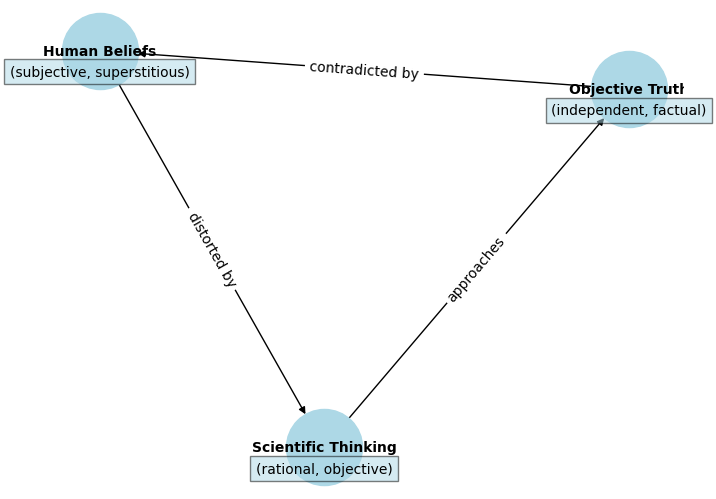

In [135]:
graph_scene_graph(structs['0017']['pro_scene_graph_history'][0])

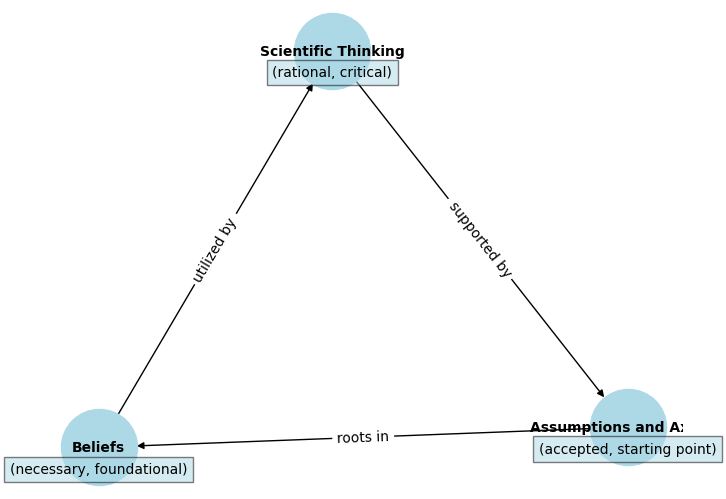

In [136]:
graph_scene_graph(structs['0017']['con_scene_graph_history'][0])

In [138]:
manager.load_debate('0017')

{'id': '0017',
 'format': 'debateart',
 'motion': {'motion': 'Faith and belief are useless in the pursuit of truth',
  'pro_side': [{'name': 'Type1'}],
  'con_side': [{'name': 'drafterman'}],
  'info_slide': 'No information',
  'speech_order': ['Type1',
   'drafterman',
   'Type1',
   'drafterman',
   'Type1',
   'drafterman']},
 'speech': [{'debater_name': 'Type1',
   'content': 'There is an objective truth, and it does not care about anyone\'s opinions or feelings.\\\nHumans are highly superstitious animals, and it is actually the norm to be delusional in human societies. There very fabric of the average human mind consists of social constructs, subjective perceptions, and superstitions that we call beliefs and opinions. The scientific method was designed to ascertain object truths about the physical mechanics of reality (although it cannot ascertain the essence of reality, what something "is". Only it\'s properties and behaviour). Even most scientists however do not think scientific

In [139]:
structs['0017']

{'pro_scene_graph_history': [{'objects': [{'id': '1',
     'name': 'Objective Truth',
     'attributes': ['independent', 'factual'],
     'relationships': {'contradicted_by': 'Human Beliefs'}},
    {'id': '2',
     'name': 'Human Beliefs',
     'attributes': ['subjective', 'superstitious'],
     'relationships': {'distorts': 'Perception of Reality'}},
    {'id': '3',
     'name': 'Scientific Thinking',
     'attributes': ['rational', 'objective'],
     'relationships': {'approaches': 'Objective Truth'}}],
   'relationships': [{'source': '1', 'target': '2', 'type': 'contradicted by'},
    {'source': '2', 'target': '3', 'type': 'distorted by'},
    {'source': '3', 'target': '1', 'type': 'approaches'}]},
  {'objects': [{'id': '1',
     'name': 'Beliefs',
     'attributes': ['unnecessary', 'potentially misleading'],
     'relationships': {'hinders': 'Truth Pursuit'}},
    {'id': '2',
     'name': 'Scientific Inquiry',
     'attributes': ['hypothesis-driven', 'evidence-based'],
     'relati